# Neural Network

In [2]:
import sys
import pandas as pd
import time
import datetime
import random
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot as plt

import numpy as np
from numpy import loadtxt
from numpy.random import seed

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Data preperation

In [3]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

In [4]:
# import data
data = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

In [6]:
# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

,onehotencoder__default_unknown,onehotencoder__default_yes,onehotencoder__contact_telephone,onehotencoder__month_aug,onehotencoder__month_dec,onehotencoder__month_jul,onehotencoder__month_jun,onehotencoder__month_mar,onehotencoder__month_may,onehotencoder__month_nov,onehotencoder__month_oct,onehotencoder__month_sep,onehotencoder__poutcome_nonexistent,onehotencoder__poutcome_success,onehotencoder__y_yes,standardscaler__age,standardscaler__previous,standardscaler__emp.var.rate,standardscaler__euribor3m,standardscaler__nr.employed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.628993,-0.349494,0.648092,0.712460,0.331680
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.290186,-0.349494,0.648092,0.712460,0.331680
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.002309,-0.349494,0.648092,0.712460,0.331680
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.164336,-0.349494,-0.752343,-1.495186,-2.815697
41184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.573445,-0.349494,-0.752343,-1.495186,-2.815697
41185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,-0.752343,-1.495186,-2.815697
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.381527,-0.349494,-0.752343,-1.495186,-2.815697


In [7]:
# check list of column names in base table
base_temp.columns.tolist()

['onehotencoder__default_unknown',
 'onehotencoder__default_yes',
 'onehotencoder__contact_telephone',
 'onehotencoder__month_aug',
 'onehotencoder__month_dec',
 'onehotencoder__month_jul',
 'onehotencoder__month_jun',
 'onehotencoder__month_mar',
 'onehotencoder__month_may',
 'onehotencoder__month_nov',
 'onehotencoder__month_oct',
 'onehotencoder__month_sep',
 'onehotencoder__poutcome_nonexistent',
 'onehotencoder__poutcome_success',
 'onehotencoder__y_yes',
 'standardscaler__age',
 'standardscaler__previous',
 'standardscaler__emp.var.rate',
 'standardscaler__euribor3m',
 'standardscaler__nr.employed']

In [8]:
# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

(41188, 19)

In [9]:
y.mean()

0.11265417111780131

In [10]:
# reset RNG's
reset_random_seeds()

# undersample data to get 50/50 success ratio using near-miss-1
undersample = NearMiss(version=1)
X, y = undersample.fit_resample(X, y)

(X_length, X_vars) = X.shape
X_length, X_vars

(9280, 19)

In [11]:
y.mean()

0.5

In [12]:
# create train/test split
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=23)

## The model
First try a model with some initial hyperparameters as a 'baseline', then perform hyperparameter tuning using grid search and random search.

In [13]:
# function returns keras NN
def create_model(hiddenLayerOne=10, learnRate=0.01):
    # reset RNG's
    reset_random_seeds()
    
    # define model (input layer (X_vars-d) > hidden layer (12-d) > output layer (1-d))
    model = tf.keras.models.Sequential()
    model.add(Dense(hiddenLayerOne, input_dim=X_vars, activation='sigmoid')) # input + hidden layer: 12 nodes + relu (TUNE #NODES!)
    model.add(Dense(1, activation='sigmoid')) # output layer: 1 node + sigmoid

    # compile model (Adam performs well (source?), AUC for comparison)
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(learning_rate=learnRate), 
        metrics=['accuracy']) # tf.keras.metrics.AUC()
    
    # return compiled model
    return model

### Hyperparameter tuning using grid search
This algorithm runs some model configurations on a dataset of 902 observations in approximately 50 minutes.

In [15]:
# for model timing
time.ctime()

'Tue Apr  5 01:32:37 2022'

In [16]:
# create model and wrap into sklearn compatible classifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# define hyperparameter search space
hiddenLayerOne = [3, 6, 10]
learnRate = [1e-1, 1e-2, 1e-3]
batchSize = [16, 32, 64, 128]
epochs = [10, 30, 50, 80]

# create dictionary from search space
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    batch_size=batchSize,
    epochs=epochs
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=cv, verbose=5, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

# for model timing
time.ctime()

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Instructions for updating:
Please use `model.predict()` instead.
[CV 1/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.888 total time=   3.0s
[CV 2/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   2.7s
[CV 3/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.915 total time=   2.4s
[CV 4/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.889 total time=   2.7s
[CV 5/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.897 total time=   2.3s
[CV 6/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.887 total time=   2.7s
[CV 7/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.912 total time=   2.6s
[CV 8/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.894 total time=   2.4s
[CV 9/10] END batch_size=16, e

[CV 5/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.901 total time=   2.8s
[CV 6/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.887 total time=   2.8s
[CV 7/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.920 total time=   2.7s
[CV 8/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.886 total time=   2.7s
[CV 9/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.889 total time=   2.6s
[CV 10/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.906 total time=   3.0s
[CV 1/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.878 total time=   2.6s
[CV 2/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.882 total time=   5.5s
[CV 3/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.902 total time=   3.1s
[CV 4/10] END batch_size=16, epoc

[CV 2/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   7.7s
[CV 3/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.925 total time=  10.5s
[CV 4/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.905 total time=   8.4s
[CV 5/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.919 total time=   9.7s
[CV 6/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.905 total time=   8.6s
[CV 7/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.927 total time=   7.2s
[CV 8/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.882 total time=  11.0s
[CV 9/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.889 total time=   8.8s
[CV 10/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.897 total time=   8.7s
[CV 1/10] END batch_size=16, epochs=30, hidde

[CV 10/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.01;, score=0.914 total time=  11.6s
[CV 1/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.896 total time=  11.4s
[CV 2/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.888 total time=  13.6s
[CV 3/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.913 total time=  13.8s
[CV 4/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.888 total time=  11.2s
[CV 5/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.903 total time=  11.5s
[CV 6/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.893 total time=  14.4s
[CV 7/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.912 total time=  12.7s
[CV 8/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.887 total time=  11.2s
[CV 9/10] END batch_size=16, epochs=5

[CV 7/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.926 total time=  18.2s
[CV 8/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.889 total time=  18.0s
[CV 9/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.887 total time=  22.0s
[CV 10/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.907 total time=  18.5s
[CV 1/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.909 total time=  18.4s
[CV 2/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.899 total time=  22.2s
[CV 3/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.928 total time=  18.5s
[CV 4/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=  17.9s
[CV 5/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.917 total time=  18.2s
[CV 6/10] END batch_size=16, epochs=80, hiddenLay

[CV 4/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.865 total time=   1.4s
[CV 5/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.878 total time=   1.4s
[CV 6/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.867 total time=   1.6s
[CV 7/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.893 total time=   1.4s
[CV 8/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.876 total time=   1.4s
[CV 9/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.870 total time=   1.6s
[CV 10/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.878 total time=   1.4s
[CV 1/10] END batch_size=32, epochs=10, hiddenLayerOne=6, learnRate=0.1;, score=0.905 total time=   1.5s
[CV 2/10] END batch_size=32, epochs=10, hiddenLayerOne=6, learnRate=0.1;, score=0.894 total time=   1.6s
[CV 3/10] END batch_size=32, epochs=10, 

[CV 1/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.906 total time=   3.8s
[CV 2/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.891 total time=   3.9s
[CV 3/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.919 total time=   3.4s
[CV 4/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.897 total time=   3.5s
[CV 5/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.913 total time=   3.4s
[CV 6/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.901 total time=   3.5s
[CV 7/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.920 total time=   3.8s
[CV 8/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.890 total time=   3.5s
[CV 9/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.887 total time=   3.5s
[CV 10/10] END batch_size=32, epochs=30, hidde

[CV 8/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.886 total time=   4.2s
[CV 9/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.882 total time=   4.4s
[CV 10/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.889 total time=   4.4s
[CV 1/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.899 total time=   5.8s
[CV 2/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   5.4s
[CV 3/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.912 total time=   5.4s
[CV 4/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.890 total time=   8.7s
[CV 5/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.895 total time=   6.3s
[CV 6/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.903 total time=   6.3s
[CV 7/10] END batch_size=32, epochs=50, hidde

[CV 6/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.912 total time=   9.7s
[CV 7/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.923 total time=   7.2s
[CV 8/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.896 total time=   6.3s
[CV 9/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.897 total time=   6.3s
[CV 10/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.914 total time=   6.7s
[CV 1/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.883 total time=   6.2s
[CV 2/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.886 total time=   6.6s
[CV 3/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.910 total time=   6.4s
[CV 4/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.884 total time=   6.5s
[CV 5/10] END batch_size=32, epo

[CV 3/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.923 total time=  10.0s
[CV 4/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.903 total time=   9.9s
[CV 5/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.913 total time=   9.9s
[CV 6/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.906 total time=  10.0s
[CV 7/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.921 total time=   9.9s
[CV 8/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.891 total time=  10.4s
[CV 9/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.897 total time=  10.0s
[CV 10/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.912 total time=  13.1s
[CV 1/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.01;, score=0.912 total time=  10.6s
[CV 2/10] END batch_size=32, epochs=80, hidd

[CV 1/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.874 total time=   0.9s
[CV 2/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.881 total time=   1.1s
[CV 3/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.896 total time=   1.0s
[CV 4/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.869 total time=   0.9s
[CV 5/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.879 total time=   0.9s
[CV 6/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.870 total time=   1.2s
[CV 7/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.892 total time=   0.9s
[CV 8/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.878 total time=   0.9s
[CV 9/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.872 total time=   0.9s
[CV 10/10] END batch_size=64, epochs=

[CV 8/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.892 total time=   2.5s
[CV 9/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.892 total time=   2.7s
[CV 10/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.908 total time=   2.3s
[CV 1/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=   2.2s
[CV 2/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.893 total time=   2.3s
[CV 3/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.923 total time=   2.2s
[CV 4/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.902 total time=   2.0s
[CV 5/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.915 total time=   2.1s
[CV 6/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.905 total time=   2.0s
[CV 7/10] END batch_size=64, epochs=30, hiddenLa

[CV 5/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.888 total time=   3.3s
[CV 6/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.880 total time=   2.9s
[CV 7/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.902 total time=   3.1s
[CV 8/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.883 total time=   3.0s
[CV 9/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.880 total time=   3.0s
[CV 10/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.887 total time=   3.0s
[CV 1/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.900 total time=   3.3s
[CV 2/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.899 total time=   6.2s
[CV 3/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.927 total time=   3.8s
[CV 4/10] END batch_size=64, epochs=50, hi

[CV 2/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   4.5s
[CV 3/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.920 total time=   4.4s
[CV 4/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.896 total time=   4.8s
[CV 5/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.912 total time=   4.9s
[CV 6/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.901 total time=   7.5s
[CV 7/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.919 total time=   5.6s
[CV 8/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   4.9s
[CV 9/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   5.0s
[CV 10/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.902 total time=   4.9s
[CV 1/10] END batch_size=64, epochs=80, hidde

[CV 9/10] END batch_size=64, epochs=80, hiddenLayerOne=10, learnRate=0.001;, score=0.884 total time=   5.9s
[CV 10/10] END batch_size=64, epochs=80, hiddenLayerOne=10, learnRate=0.001;, score=0.894 total time=   5.2s
[CV 1/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.900 total time=   0.6s
[CV 2/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   0.6s
[CV 3/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.918 total time=   0.6s
[CV 4/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.888 total time=   0.6s
[CV 5/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.907 total time=   0.6s
[CV 6/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.902 total time=   0.6s
[CV 7/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.917 total time=   0.6s
[CV 8/10] END batch_size=128, epochs=10, 

[CV 6/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.885 total time=   1.1s
[CV 7/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.905 total time=   0.7s
[CV 8/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.889 total time=   0.7s
[CV 9/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.883 total time=   0.7s
[CV 10/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.891 total time=   0.7s
[CV 1/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.871 total time=   0.7s
[CV 2/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.876 total time=   0.7s
[CV 3/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.892 total time=   0.8s
[CV 4/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.861 total time=   0.7s
[CV 5/10] END batch_siz

[CV 3/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.931 total time=   1.3s
[CV 4/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.912 total time=   1.3s
[CV 5/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.920 total time=   1.3s
[CV 6/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.907 total time=   1.3s
[CV 7/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.925 total time=   1.8s
[CV 8/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   1.3s
[CV 9/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   1.3s
[CV 10/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.906 total time=   1.3s
[CV 1/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.01;, score=0.906 total time=   1.6s
[CV 2/10] END batch_size=128, epoch

[CV 10/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=   2.5s
[CV 1/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.879 total time=   2.0s
[CV 2/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.883 total time=   1.9s
[CV 3/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.903 total time=   2.2s
[CV 4/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.877 total time=   1.8s
[CV 5/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.887 total time=   1.8s
[CV 6/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.880 total time=   1.8s
[CV 7/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.901 total time=   1.9s
[CV 8/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.883 total time=   1.8s
[CV 9/10] END batch_size=128

[CV 7/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.924 total time=   2.8s
[CV 8/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.885 total time=   2.7s
[CV 9/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.898 total time=   2.7s
[CV 10/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.908 total time=   2.8s
[CV 1/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.913 total time=   2.7s
[CV 2/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.893 total time=   3.1s
[CV 3/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.927 total time=   2.8s
[CV 4/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.906 total time=   2.7s
[CV 5/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.916 total time=   2.7s
[CV 6/10] END batch_size=128, epochs=80,

'Tue Apr  5 03:43:36 2022'

## Overfitting check
Vary amout of epochs over several model runs.

58/58 [==============================] - 0s 998us/step - loss: 0.3086 - accuracy: 0.8691
n_estimator: 1, train: 0.925, test: 0.902
Epoch 1/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3087 - accuracy: 0.8689
Epoch 2/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8685
Epoch 3/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8689
Epoch 4/21
58/58 [==============================] - 0s 964us/step - loss: 0.3080 - accuracy: 0.8681
Epoch 5/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3086 - accuracy: 0.8672
Epoch 6/21
58/58 [==============================] - 0s 970us/step - loss: 0.3083 - accuracy: 0.8683
Epoch 7/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8707
Epoch 8/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.8685
Epoch 9/21
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - 

58/58 [==============================] - 0s 980us/step - loss: 0.3081 - accuracy: 0.8703
Epoch 19/61
58/58 [==============================] - 0s 914us/step - loss: 0.3085 - accuracy: 0.8684
Epoch 20/61
58/58 [==============================] - 0s 980us/step - loss: 0.3081 - accuracy: 0.8703
Epoch 21/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8691
Epoch 22/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3088 - accuracy: 0.8681
Epoch 23/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8685
Epoch 24/61
58/58 [==============================] - 0s 970us/step - loss: 0.3083 - accuracy: 0.8688
Epoch 25/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8680
Epoch 26/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3091 - accuracy: 0.8691
Epoch 27/61
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8683
Epoch 28/61
58

58/58 [==============================] - 0s 860us/step - loss: 0.3082 - accuracy: 0.8669
Epoch 39/81
58/58 [==============================] - 0s 877us/step - loss: 0.3089 - accuracy: 0.8700
Epoch 40/81
58/58 [==============================] - 0s 740us/step - loss: 0.3084 - accuracy: 0.8691
Epoch 41/81
58/58 [==============================] - 0s 688us/step - loss: 0.3082 - accuracy: 0.8671
Epoch 42/81
58/58 [==============================] - 0s 774us/step - loss: 0.3080 - accuracy: 0.8707
Epoch 43/81
58/58 [==============================] - 0s 722us/step - loss: 0.3082 - accuracy: 0.8687
Epoch 44/81
58/58 [==============================] - 0s 791us/step - loss: 0.3085 - accuracy: 0.8702
Epoch 45/81
58/58 [==============================] - 0s 929us/step - loss: 0.3078 - accuracy: 0.8689
Epoch 46/81
58/58 [==============================] - 0s 1ms/step - loss: 0.3085 - accuracy: 0.8692
Epoch 47/81
58/58 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8685
Epoch 

58/58 [==============================] - 0s 888us/step - loss: 0.3089 - accuracy: 0.8688
Epoch 38/101
58/58 [==============================] - 0s 968us/step - loss: 0.3082 - accuracy: 0.8673
Epoch 39/101
58/58 [==============================] - 0s 935us/step - loss: 0.3089 - accuracy: 0.8700
Epoch 40/101
58/58 [==============================] - 0s 942us/step - loss: 0.3084 - accuracy: 0.8689
Epoch 41/101
58/58 [==============================] - 0s 968us/step - loss: 0.3081 - accuracy: 0.8671
Epoch 42/101
58/58 [==============================] - 0s 987us/step - loss: 0.3079 - accuracy: 0.8707
Epoch 43/101
58/58 [==============================] - 0s 976us/step - loss: 0.3082 - accuracy: 0.8687
Epoch 44/101
58/58 [==============================] - 0s 986us/step - loss: 0.3085 - accuracy: 0.8702
Epoch 45/101
58/58 [==============================] - 0s 1ms/step - loss: 0.3078 - accuracy: 0.8689
Epoch 46/101
58/58 [==============================] - 0s 881us/step - loss: 0.3084 - accuracy: 0.

58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8691
Epoch 17/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8700
Epoch 18/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8703
Epoch 19/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.8687
Epoch 20/121
58/58 [==============================] - 0s 835us/step - loss: 0.3080 - accuracy: 0.8702
Epoch 21/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3084 - accuracy: 0.8693
Epoch 22/121
58/58 [==============================] - 0s 982us/step - loss: 0.3087 - accuracy: 0.8685
Epoch 23/121
58/58 [==============================] - 0s 918us/step - loss: 0.3084 - accuracy: 0.8687
Epoch 24/121
58/58 [==============================] - 0s 892us/step - loss: 0.3082 - accuracy: 0.8691
Epoch 25/121
58/58 [==============================] - 0s 861us/step - loss: 0.3092 - accuracy: 0.8683
Epo

Epoch 97/121
58/58 [==============================] - 0s 775us/step - loss: 0.3082 - accuracy: 0.8687
Epoch 98/121
58/58 [==============================] - 0s 757us/step - loss: 0.3085 - accuracy: 0.8693
Epoch 99/121
58/58 [==============================] - 0s 757us/step - loss: 0.3083 - accuracy: 0.8684
Epoch 100/121
58/58 [==============================] - 0s 792us/step - loss: 0.3079 - accuracy: 0.8688
Epoch 101/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3080 - accuracy: 0.8681
Epoch 102/121
58/58 [==============================] - 0s 797us/step - loss: 0.3080 - accuracy: 0.8702
Epoch 103/121
58/58 [==============================] - 0s 777us/step - loss: 0.3085 - accuracy: 0.8683
Epoch 104/121
58/58 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.8693
Epoch 105/121
58/58 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8693
Epoch 106/121
58/58 [==============================] - 0s 791us/step - loss: 0.307

58/58 [==============================] - 0s 895us/step - loss: 0.3078 - accuracy: 0.8699
Epoch 57/141
58/58 [==============================] - 0s 862us/step - loss: 0.3077 - accuracy: 0.8692
Epoch 58/141
58/58 [==============================] - 0s 894us/step - loss: 0.3084 - accuracy: 0.8684
Epoch 59/141
58/58 [==============================] - 0s 858us/step - loss: 0.3083 - accuracy: 0.8691
Epoch 60/141
58/58 [==============================] - 0s 920us/step - loss: 0.3083 - accuracy: 0.8699
Epoch 61/141
58/58 [==============================] - 0s 917us/step - loss: 0.3077 - accuracy: 0.8692
Epoch 62/141
58/58 [==============================] - 0s 857us/step - loss: 0.3085 - accuracy: 0.8692
Epoch 63/141
58/58 [==============================] - 0s 843us/step - loss: 0.3080 - accuracy: 0.8699
Epoch 64/141
58/58 [==============================] - 0s 880us/step - loss: 0.3086 - accuracy: 0.8683
Epoch 65/141
58/58 [==============================] - 0s 1ms/step - loss: 0.3082 - accuracy: 0.

58/58 [==============================] - 0s 910us/step - loss: 0.3080 - accuracy: 0.8699
Epoch 137/141
58/58 [==============================] - 0s 903us/step - loss: 0.3080 - accuracy: 0.8679
Epoch 138/141
58/58 [==============================] - 0s 960us/step - loss: 0.3080 - accuracy: 0.8699
Epoch 139/141
58/58 [==============================] - 0s 914us/step - loss: 0.3080 - accuracy: 0.8683
Epoch 140/141
58/58 [==============================] - 0s 889us/step - loss: 0.3085 - accuracy: 0.8683
Epoch 141/141
58/58 [==============================] - 0s 922us/step - loss: 0.3082 - accuracy: 0.8685
n_estimator: 141, train: 0.925, test: 0.902
Epoch 1/161
58/58 [==============================] - 0s 831us/step - loss: 0.3087 - accuracy: 0.8688
Epoch 2/161
58/58 [==============================] - 0s 840us/step - loss: 0.3077 - accuracy: 0.8687
Epoch 3/161
58/58 [==============================] - 0s 895us/step - loss: 0.3083 - accuracy: 0.8688
Epoch 4/161
58/58 [==============================

58/58 [==============================] - 0s 900us/step - loss: 0.3076 - accuracy: 0.8692
Epoch 76/161
58/58 [==============================] - 0s 895us/step - loss: 0.3079 - accuracy: 0.8696
Epoch 77/161
58/58 [==============================] - 0s 852us/step - loss: 0.3079 - accuracy: 0.8700
Epoch 78/161
58/58 [==============================] - 0s 888us/step - loss: 0.3080 - accuracy: 0.8675
Epoch 79/161
58/58 [==============================] - 0s 850us/step - loss: 0.3084 - accuracy: 0.8693
Epoch 80/161
58/58 [==============================] - 0s 854us/step - loss: 0.3079 - accuracy: 0.8691
Epoch 81/161
58/58 [==============================] - 0s 835us/step - loss: 0.3079 - accuracy: 0.8706
Epoch 82/161
58/58 [==============================] - 0s 901us/step - loss: 0.3079 - accuracy: 0.8695
Epoch 83/161
58/58 [==============================] - 0s 1ms/step - loss: 0.3074 - accuracy: 0.8680
Epoch 84/161
58/58 [==============================] - 0s 901us/step - loss: 0.3079 - accuracy: 0.

58/58 [==============================] - 0s 997us/step - loss: 0.3073 - accuracy: 0.8711
Epoch 156/161
58/58 [==============================] - 0s 1ms/step - loss: 0.3074 - accuracy: 0.8689
Epoch 157/161
58/58 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.8689
Epoch 158/161
58/58 [==============================] - 0s 963us/step - loss: 0.3074 - accuracy: 0.8693
Epoch 159/161
58/58 [==============================] - 0s 774us/step - loss: 0.3074 - accuracy: 0.8677
Epoch 160/161
58/58 [==============================] - 0s 871us/step - loss: 0.3074 - accuracy: 0.8700
Epoch 161/161
58/58 [==============================] - 0s 671us/step - loss: 0.3072 - accuracy: 0.8684
n_estimator: 161, train: 0.925, test: 0.901
Epoch 1/181
58/58 [==============================] - 0s 826us/step - loss: 0.3085 - accuracy: 0.8692
Epoch 2/181
58/58 [==============================] - 0s 819us/step - loss: 0.3074 - accuracy: 0.8691
Epoch 3/181
58/58 [==============================] 

58/58 [==============================] - 0s 944us/step - loss: 0.3084 - accuracy: 0.8692
Epoch 75/181
58/58 [==============================] - 0s 856us/step - loss: 0.3073 - accuracy: 0.8695
Epoch 76/181
58/58 [==============================] - 0s 852us/step - loss: 0.3076 - accuracy: 0.8697
Epoch 77/181
58/58 [==============================] - 0s 883us/step - loss: 0.3076 - accuracy: 0.8706
Epoch 78/181
58/58 [==============================] - 0s 1ms/step - loss: 0.3077 - accuracy: 0.8677
Epoch 79/181
58/58 [==============================] - 0s 1ms/step - loss: 0.3081 - accuracy: 0.8688
Epoch 80/181
58/58 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8689
Epoch 81/181
58/58 [==============================] - 0s 944us/step - loss: 0.3076 - accuracy: 0.8704
Epoch 82/181
58/58 [==============================] - 0s 831us/step - loss: 0.3076 - accuracy: 0.8693
Epoch 83/181
58/58 [==============================] - 0s 899us/step - loss: 0.3071 - accuracy: 0.8683

58/58 [==============================] - 0s 928us/step - loss: 0.3075 - accuracy: 0.8684
Epoch 155/181
58/58 [==============================] - 0s 898us/step - loss: 0.3072 - accuracy: 0.8712
Epoch 156/181
58/58 [==============================] - 0s 911us/step - loss: 0.3073 - accuracy: 0.8691
Epoch 157/181
58/58 [==============================] - 0s 938us/step - loss: 0.3072 - accuracy: 0.8689
Epoch 158/181
58/58 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.8699
Epoch 159/181
58/58 [==============================] - 0s 2ms/step - loss: 0.3073 - accuracy: 0.8680
Epoch 160/181
58/58 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.8697
Epoch 161/181
58/58 [==============================] - 0s 1ms/step - loss: 0.3071 - accuracy: 0.8681
Epoch 162/181
58/58 [==============================] - 0s 913us/step - loss: 0.3081 - accuracy: 0.8673
Epoch 163/181
58/58 [==============================] - 0s 909us/step - loss: 0.3080 - accuracy:

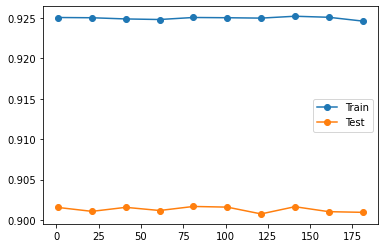

In [40]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
#values = np.geomspace(1, 200, num=20, dtype=int)
values = range(1, 200, 20)
for i in values:
    # create and train model on training data
    overfit_model = create_model(hiddenLayerOne=10, learnRate=0.1)
    model.fit(train_features, train_targets, epochs=i, batch_size=128)
    
    # evaluate on the train dataset
    prediction_train = model.predict(train_features)
    train_auc = roc_auc_score(train_targets, prediction_train)
    train_scores.append(train_auc)
    
    # evaluate on the test dataset
    prediction_test = model.predict(test_features)
    test_auc = roc_auc_score(test_targets, prediction_test)
    test_scores.append(test_auc)
    
    # summarize progress
    print('n_estimator: %.0f, train: %.3f, test: %.3f' % (i, train_auc, test_auc))
# plot of train and test scores vs n_estimator
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

#### Overfitting conclusion:
We can conclude that ~100 epochs results in the highest validation AUC, although the performance gain after 70 epocs is very small. Buy given the relatively short running time of this model, we decide to use 100 epochs in the final model.

## Final Model
Run model using the best hyperparameter combination and 100 eopchs. Compute AUC for model comparison purposes.

Epoch 1/100
58/58 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7982
Epoch 2/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3949 - accuracy: 0.8129
Epoch 3/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3874 - accuracy: 0.8171
Epoch 4/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8289
Epoch 5/100
58/58 [==============================] - 0s 860us/step - loss: 0.3696 - accuracy: 0.8377
Epoch 6/100
58/58 [==============================] - 0s 808us/step - loss: 0.3652 - accuracy: 0.8388
Epoch 7/100
58/58 [==============================] - 0s 859us/step - loss: 0.3624 - accuracy: 0.8389
Epoch 8/100
58/58 [==============================] - 0s 825us/step - loss: 0.3617 - accuracy: 0.8371
Epoch 9/100
58/58 [==============================] - 0s 791us/step - loss: 0.3614 - accuracy: 0.8408
Epoch 10/100
58/58 [==============================] - 0s 860us/step - loss: 0.3560 - accuracy: 0.84

58/58 [==============================] - 0s 846us/step - loss: 0.3351 - accuracy: 0.8551
Epoch 82/100
58/58 [==============================] - 0s 910us/step - loss: 0.3329 - accuracy: 0.8592
Epoch 83/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3354 - accuracy: 0.8567
Epoch 84/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3362 - accuracy: 0.8555
Epoch 85/100
58/58 [==============================] - 0s 843us/step - loss: 0.3342 - accuracy: 0.8565
Epoch 86/100
58/58 [==============================] - 0s 756us/step - loss: 0.3366 - accuracy: 0.8564
Epoch 87/100
58/58 [==============================] - 0s 808us/step - loss: 0.3337 - accuracy: 0.8580
Epoch 88/100
58/58 [==============================] - 0s 903us/step - loss: 0.3343 - accuracy: 0.8547
Epoch 89/100
58/58 [==============================] - 0s 859us/step - loss: 0.3341 - accuracy: 0.8565
Epoch 90/100
58/58 [==============================] - 0s 843us/step - loss: 0.3356 - accuracy: 0.85

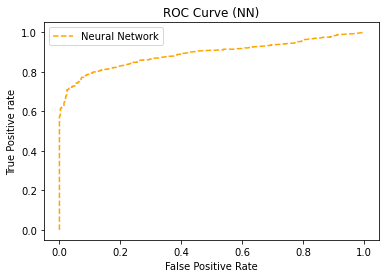

AUC Score: 0.89


In [15]:
# create final model
fin_model = create_model(hiddenLayerOne=10, learnRate=0.1)

# fit model on the dataset
fin_model.fit(train_features, train_targets, epochs=100, batch_size=128)

# predict marketing success for test dataset
predictions = fin_model.predict_classes(test_features)
    
# print conf mat and classification report
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))
print("Classification Report")
print(classification_report(test_targets, predictions))

# plot ROC-curve
pred_prob = fin_model.predict(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob, pos_label=1) #[:,1]
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Neural Network')

# title
plt.title('ROC Curve (NN)')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
# AUC Score
auc_score = roc_auc_score(test_targets, pred_prob) #[:,1]
print("AUC Score: " + str(np.round(auc_score , 3)))